In [3]:
!pip install pulp
!pip install yfinance
!pip install cvxpy
import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pulp
import scipy.linalg as la
import yfinance as yf

### Selected stock

In [2]:

# Define the symbols for stocks and bonds
assets = [ "MSFT", "GOOGL", "ICSH", "RYSE", "XBIL", "RATE", "GC=F"]

# Fetch historical data for each symbol
data = {}
for symbol in assets:
    data[symbol] = yf.download(symbol, period="1y")

# Create a DataFrame to store the close prices
close_prices = pd.DataFrame(columns=assets)

# Populate the DataFrame with close prices
for symbol in assets:
    close_prices[symbol] = data[symbol]['Close']
close_prices.dropna(inplace=True)

# Display the DataFrame
print(close_prices)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

                  MSFT       GOOGL       ICSH       RYSE       XBIL  \
Date                                                                  
2023-04-12  283.489990  104.639999  50.189999  25.660000  50.119999   
2023-04-13  289.839996  107.430000  50.209999  25.830000  50.139999   
2023-04-14  286.140015  108.870003  50.200001  26.069000  50.130001   
2023-04-17  288.799988  105.970001  50.189999  26.379999  50.130001   
2023-04-18  288.369995  104.500000  50.200001  26.305000  50.130001   
...                ...         ...        ...        ...        ...   
2024-04-05  425.519989  152.500000  50.380001  24.788000  49.950001   
2024-04-08  424.589996  154.850006  50.389999  24.900000  49.950001   
2024-04-09  426.279999  156.600006  50.400002  24.598000  49.950001   
2024-04-10  423.260010  156.139999  50.369999  25.480000  49.955002   
2024-04-11  427.929993  159.410004  50.389999  25.355000  49.980000   

                 RATE         GC=F  
Date                                
20

In [3]:
returns = {}
for symbol in close_prices.columns:
    close = close_prices[symbol].values
    T = 1  # Number of days in time period
    # Check if there are enough data points for calculation
    if len(close) > T:
        returns[symbol] = (close[T:] - close[:-T]) / close[:-T]

# Convert returns dictionary to DataFrame
R = pd.DataFrame(returns)
R.fillna(0.000658, inplace=True)

# Display the returns DataFrame
print(R)

         MSFT     GOOGL      ICSH      RYSE      XBIL      RATE      GC=F
0    0.022399  0.026663  0.000398  0.006625  0.000399  0.003205  0.015118
1   -0.012766  0.013404 -0.000199  0.009253 -0.000199  0.005612 -0.019155
2    0.009296 -0.026637 -0.000199  0.011930  0.000000  0.035674 -0.003996
3   -0.001489 -0.013872  0.000199 -0.002843  0.000000 -0.010363  0.006619
4    0.000277 -0.003062  0.000000  0.003611 -0.000200 -0.009927 -0.006078
..        ...       ...       ...       ...       ...       ...       ...
246  0.018283  0.013087  0.000000  0.016652  0.000000  0.023012  0.016122
247 -0.002186  0.015410  0.000198  0.004518  0.000000  0.010795  0.002580
248  0.003980  0.011301  0.000198 -0.012129  0.000000 -0.019920  0.005061
249 -0.007085 -0.002937 -0.000595  0.035857  0.000100  0.059554 -0.005931
250  0.011033  0.020943  0.000397 -0.004906  0.000500  0.017029  0.010817

[251 rows x 7 columns]


In [4]:
r = R.mean()

# Display the mean return for each symbol
print("Mean Return for Each Symbol:")
print(r)

Mean Return for Each Symbol:
MSFT     0.001736
GOOGL    0.001826
ICSH     0.000016
RYSE     0.000077
XBIL    -0.000011
RATE    -0.000047
GC=F     0.000658
dtype: float64


In [5]:
# Compute covariance between each symbol
S = np.cov(R.T)

# Display the covariance matrix
print("Covariance Matrix:")
print(S)

Covariance Matrix:
[[ 1.90694605e-04  9.96826288e-05 -7.73408106e-07  4.47615617e-06
  -6.13455189e-07  1.19278546e-05 -3.98006029e-06]
 [ 9.96826288e-05  2.94431863e-04 -6.22262592e-07 -6.14608378e-06
  -1.78679007e-07 -1.79243024e-05 -4.75204464e-06]
 [-7.73408106e-07 -6.22262592e-07  8.79915913e-07 -1.74970130e-06
   7.55276740e-07 -7.15536179e-07  2.74259220e-07]
 [ 4.47615617e-06 -6.14608378e-06 -1.74970130e-06  2.32511154e-04
  -7.34285515e-07  2.78765534e-04 -2.74492559e-05]
 [-6.13455189e-07 -1.78679007e-07  7.55276740e-07 -7.34285515e-07
   9.00006277e-07 -1.83367246e-07 -9.78862121e-08]
 [ 1.19278546e-05 -1.79243024e-05 -7.15536179e-07  2.78765534e-04
  -1.83367246e-07  5.28909892e-04 -2.06358380e-05]
 [-3.98006029e-06 -4.75204464e-06  2.74259220e-07 -2.74492559e-05
  -9.78862121e-08 -2.06358380e-05  5.81161128e-05]]


In [4]:
from datetime import datetime, timedelta, date

In [5]:
end_date = datetime.today()
start_date = end_date - timedelta(days = 1*365)

assets = ["MSFT", "GOOGL", "ICSH", "XBIL", "GC=F"]

close = pd.DataFrame()
for s in assets:
    data = yf.download(s, start=start_date, end=end_date)
    close[s] = data['Adj Close']

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


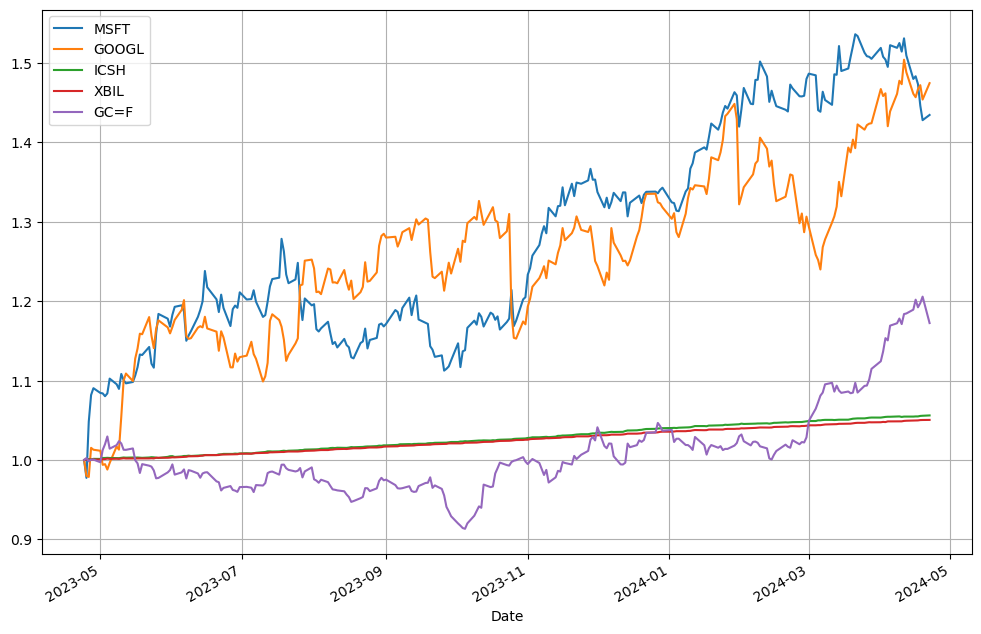

In [6]:
returns=close/close.iloc[0]
returns=returns.dropna()
returns.plot(kind='line',figsize=(12,8),grid=True)
plt.legend(loc='best')

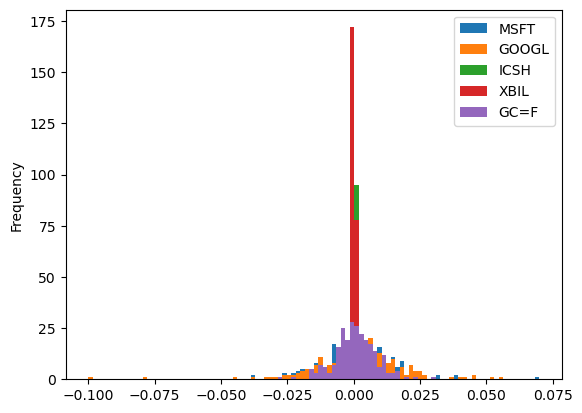

In [7]:
# plotting log return
log_ret=np.log(close/close.shift(1))
log_ret = log_ret.dropna()
log_ret.plot.hist(bins=100)
plt.legend(loc='best')

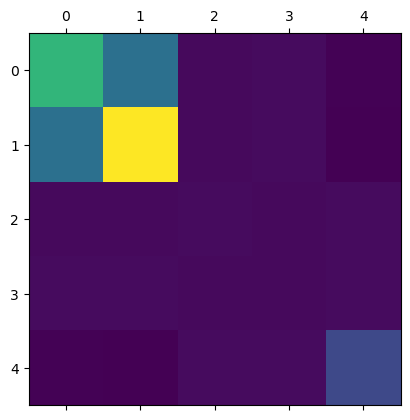

In [8]:
#The sum of the average logarithmic returns of 252 days
mean_ret=log_ret.mean()*252
#252 days of assets constitute a bias matrix
total_covar=log_ret.cov()*252
plt.matshow(total_covar)

In [9]:
R = log_ret.to_numpy()
r = mean_ret.to_numpy()
S = np.cov(R.T)

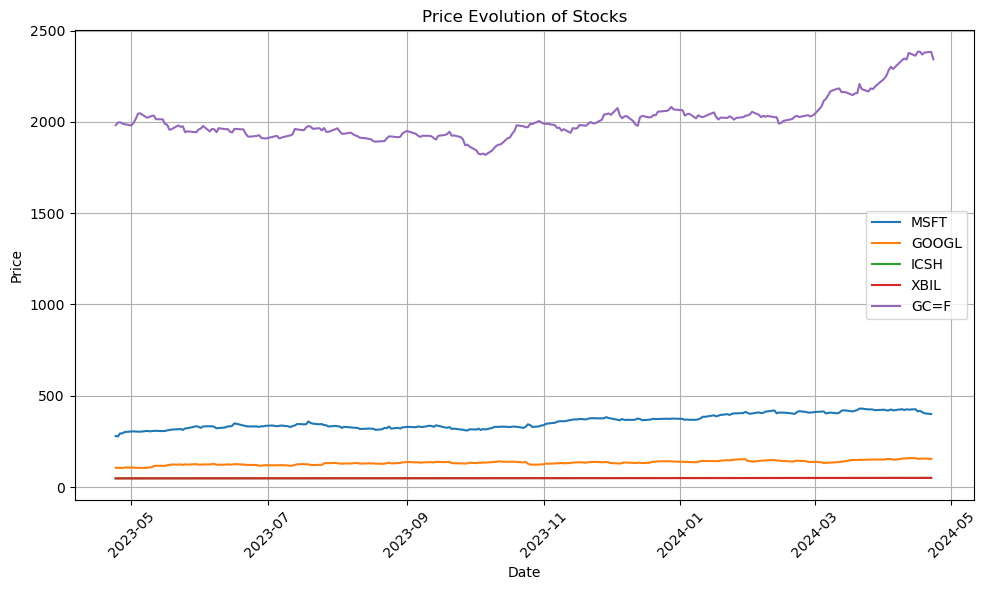

In [10]:
# Create a single plot for all stocks
plt.figure(figsize=(10, 6))

# Plot price evolution of each stock
for stock in assets:
    data = yf.Ticker(stock)
    df = data.history(period="1y")
    plt.plot(df.index, df["Open"], label=stock)

plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Price Evolution of Stocks")
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## Model 1A

In [12]:
from pulp import *
import numpy as np

# Define the data
n = len(assets)  # Number of assets
T = len(R)  # Number of time periods
r0 = 0.2


# Create a LP problem
prob = LpProblem("Financial_Portfolio_Optimization", LpMaximize)

# Define decision variables
x = [LpVariable(f"x{j}", lowBound=0) for j in range(n)]
y = [LpVariable(f"y{t}", lowBound=0) for t in range(T)]

# Define objective function
prob += -(1 / T) * lpSum(y[t] for t in range(T)), "Objective"

# Define constraints
for t in range(T):
    prob += (
        lpSum(x[j] * (R[t][j] - r[j]) for j in range(n)) <= y[t],
        f"Upper_constraint_{t}",
    )
    prob += (
        lpSum(x[j] * (R[t][j] - r[j]) for j in range(n)) >= -y[t],
        f"Lower_constraint_{t}",
    )

prob += lpSum(r[j] * x[j] for j in range(n)) == r0

prob += lpSum(x) == 1, "Sum_of_weights"

# Solve the problem
prob.solve()

# Print the results
print("Status:", LpStatus[prob.status])
print("Optimal Portfolio Weights:")
for j in range(n):
    print(f"x{j}: {value(x[j])}")
print("Expected Return (MAD):", value(lpSum(r[j] * x[j] for j in range(n))))
print("Mean Absolute Deviation (MAD):", value((1 / T) * lpSum(y[t] for t in range(T))))


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/b5cd191d054c4e85acdc60d2940e7907-pulp.mps max timeMode elapsed branch printingOptions all solution /tmp/b5cd191d054c4e85acdc60d2940e7907-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 507 COLUMNS
At line 3768 RHS
At line 4271 BOUNDS
At line 4272 ENDATA
Problem MODEL has 502 rows, 255 columns and 3010 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 252 (-250) rows, 255 (0) columns and 1510 (-1500) elements
Perturbing problem by 0.001% of 0.0007024833 - largest nonzero change 9.971747e-07 ( 0.16065227%) - largest zero change 8.2593663e-07
0  Obj -0 Primal inf 2.1609048 (2)
31  Obj -0.022901298 Primal inf 491.04468 (197)
65  Obj -0.049490122 Primal inf 1764.486 (146)
100  Obj -0.077571571 Primal inf 2365.617 (141)
135  Obj -0.10527868 Pr

## Model 1B

In [13]:
from pulp import *

# Define the data
n = len(assets)  # Number of assets
T = len(R[:, 0])  # Number of time periods
m0 = 0.05

# Create a LP problem
prob = LpProblem("Financial_Portfolio_Optimization", LpMaximize)

# Define decision variables
x = [LpVariable(f"x{j}", lowBound=0) for j in range(n)]
y = [LpVariable(f"y{t}", lowBound=0) for t in range(T)]

# Define objective function
prob += lpSum(r[j] * x[j] for j in range(n)), "Objective"

# Define constraints
for t in range(T):
    prob += (
        lpSum(x[j] * (R[t][j] - r[j]) for j in range(n)) <= y[t],
        f"Upper_constraint_{t}",
    )
    prob += (
        lpSum(x[j] * (R[t][j] - r[j]) for j in range(n)) >= -y[t],
        f"Lower_constraint_{t}",
    )

prob += (1 / T) * lpSum(y[t] for t in range(T)) <= m0, "Risk"

prob += lpSum(x) == 1, "Sum_of_weights"

# Solve the problem
prob.solve()

# Print the results
print("Status:", LpStatus[prob.status])
print("Optimal Portfolio Weights:")
for j in range(n):
    print(f"x{j}: {value(x[j])}")
print("Expected Return (MAD):", value(lpSum(r[j] * x[j] for j in range(n))))
print("Mean Absolute Deviation (MAD):", value((1 / T) * lpSum(y[t] for t in range(T))))


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/d13695646eed4a85b00cb1374fbba5e8-pulp.mps max timeMode elapsed branch printingOptions all solution /tmp/d13695646eed4a85b00cb1374fbba5e8-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 507 COLUMNS
At line 3768 RHS
At line 4271 BOUNDS
At line 4272 ENDATA
Problem MODEL has 502 rows, 255 columns and 3255 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 252 (-250) rows, 255 (0) columns and 1755 (-1500) elements
Perturbing problem by 0.001% of 0.20099921 - largest nonzero change 8.6649638e-05 ( 0.12504048%) - largest zero change 4.9955383e-05
0  Obj -0 Primal inf 27.345922 (2) Dual inf 0.69309153 (5)
33  Obj 0.39215206 Primal inf 385.57881 (221)
113  Obj 0.39037127 Primal inf 525.17097 (143)
193  Obj 0.38855681 Primal inf 664.97525 (63)
246 

### Model 1C

In [14]:
from pulp import *

# Define the data
n = len(assets)  # Number of assets
T = len(R[:, 0])  # Number of time periods
mu = 0.5

# Create a LP problem
prob = LpProblem("Financial_Portfolio_Optimization", LpMaximize)

# Define decision variables
x = [LpVariable(f"x{j}", lowBound=0) for j in range(n)]
y = [LpVariable(f"y{t}", lowBound=0) for t in range(T)]

# Define objective function
prob += lpSum(r[j] * x[j] for j in range(n)) * mu - (1 / T) * lpSum(y[t] for t in range(T)), "Objective"

# Define constraints
for t in range(T):
    prob += lpSum(x[j] * (R[t][j] - r[j]) for j in range(n)) <= y[t], f"Upper_constraint_{t}"
    prob += lpSum(x[j] * (R[t][j] - r[j]) for j in range(n)) >= -y[t], f"Lower_constraint_{t}"

prob += lpSum(x) == 1, "Sum_of_weights"

# Solve the problem
prob.solve()

# Print the results
print("Status:", LpStatus[prob.status])
print("Optimal Portfolio Weights:")
for j in range(n):
    print(f"x{j}: {value(x[j])}")
print("Expected Return (MAD):", value(lpSum(r[j] * x[j] for j in range(n))))
print("Mean Absolute Deviation (MAD):", value((1 / T) * lpSum(y[t] for t in range(T))))


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/8d4caefbaa5b4f0d90b145ede773acca-pulp.mps max timeMode elapsed branch printingOptions all solution /tmp/8d4caefbaa5b4f0d90b145ede773acca-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 506 COLUMNS
At line 3767 RHS
At line 4269 BOUNDS
At line 4270 ENDATA
Problem MODEL has 501 rows, 255 columns and 3005 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 251 (-250) rows, 255 (0) columns and 1505 (-1500) elements
Perturbing problem by 0.001% of 0.080027495 - largest nonzero change 8.5521543e-05 ( 0.24896474%) - largest zero change 0
0  Obj -0 Primal inf 0.83602919 (1) Dual inf 0.28792962 (5)
80  Obj 0.19360512 Primal inf 1122.9625 (171)
160  Obj -0.0067211008 Primal inf 26.60692 (91)
240  Obj -0.022561051 Primal inf 3.1274359 (11)
251  Obj -0

## Efficient Frontier for 1xx Model

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/b35b58ffc70145f3aaff5ba7745f3bb9-pulp.mps max timeMode elapsed branch printingOptions all solution /tmp/b35b58ffc70145f3aaff5ba7745f3bb9-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 507 COLUMNS
At line 3768 RHS
At line 4271 BOUNDS
At line 4272 ENDATA
Problem MODEL has 502 rows, 255 columns and 3010 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 462 (-40) rows, 255 (0) columns and 2770 (-240) elements
Perturbing problem by 0.001% of 0.0070104683 - largest nonzero change 4.9861538e-05 ( 25.957919%) - largest zero change 4.0816135e-05
0  Obj -4.7085178e-07 Primal inf 3.0003478 (252)
49  Obj -0.00021046519 Primal inf 92.65887 (240)
96  Obj -0.00028192065 Primal inf 23.572773 (201)
139  Obj -0.00033395927 Primal inf 21.900559 (181)
186 

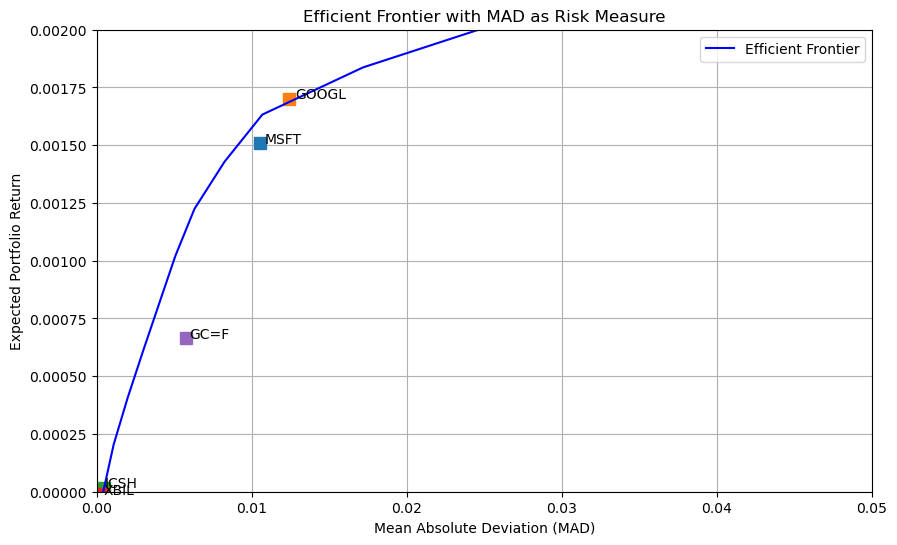

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
from scipy import stats
from pulp import *

# Define the symbols for stocks and bonds
assets = ["MSFT", "GOOGL", "ICSH", "XBIL", "GC=F"]

# Fetch historical data for each symbol
data = {}
for symbol in assets:
    data[symbol] = yf.download(symbol, period="1y")

# Create a DataFrame to store the close prices
close_prices = pd.DataFrame(columns=assets)

# Populate the DataFrame with close prices
for symbol in assets:
    close_prices[symbol] = data[symbol]['Close']
close_prices.dropna(inplace=True)

# Calculate returns
returns = close_prices.pct_change().dropna()

# Mean return and mean absolute deviation
mean_return = returns.mean()
mean_absolute_deviation = returns.abs().mean()

# Define the efficient frontier function
def efficient_frontier(R, assets):
    # Define the data
    n = len(assets)  # Number of assets
    T = len(R[:, 0])  # Number of time periods

    m0_array = np.linspace(0.0, 0.01, 50)
    risk_array = np.zeros_like(m0_array)
    portfolio_returns = []
    portfolio_mads = []

    for i, m0 in enumerate(m0_array):
        # Create a LP problem
        prob = LpProblem("Financial_Portfolio_Optimization", LpMaximize)

        # Define decision variables
        x = [LpVariable(f"x{j}", lowBound=0) for j in range(n)]
        y = [LpVariable(f"y{t}", lowBound=0) for t in range(T)]

        # Define objective function
        prob += -(1 / T) * lpSum(y[t] for t in range(T)), "Objective"

        # Define constraints
        for t in range(T):
            prob += (
                lpSum(x[j] * (R[t][j] - mean_return[j]) for j in range(n)) <= y[t],
                f"Upper_constraint_{t}",
            )
            prob += (
                lpSum(x[j] * (R[t][j] - mean_return[j]) for j in range(n)) >= -y[t],
                f"Lower_constraint_{t}",
            )

        prob += lpSum(mean_return[j] * x[j] for j in range(n)) == m0

        prob += lpSum(x) == 1, "Sum_of_weights"

        # Solve the problem
        prob.solve()
        
        # Calculate portfolio return and MAD
        portfolio_return = value(lpSum(mean_return[j] * x[j] for j in range(n)))
        portfolio_mad = value((1 / T) * lpSum(y[t] for t in range(T)))

        # Store portfolio return and MAD
        portfolio_returns.append(portfolio_return)
        portfolio_mads.append(portfolio_mad)

        # Store risk
        risk_array[i] = portfolio_mad
    
    return risk_array, portfolio_returns, portfolio_mads

# Calculate efficient frontier points
risk_array, portfolio_returns, portfolio_mads = efficient_frontier(returns.values, assets)

# Fit a linear regression line to the efficient frontier points
slope, intercept, _, _, _ = stats.linregress(risk_array, portfolio_returns)
efficient_line = slope * risk_array + intercept

# Plot both plots on the same graph
fig, ax = plt.subplots(figsize=(10, 6))

# Plot daily return versus mean absolute deviation
for i, asset in enumerate(assets):
    ax.plot(mean_absolute_deviation[i], mean_return[i], "s", ms=8)
    ax.text(mean_absolute_deviation[i] * 1.03, mean_return[i], asset)

ax.set_title("Daily return versus Mean Absolute Deviation")
ax.set_xlabel("Mean Absolute Deviation in Daily Returns")
ax.set_ylabel("Mean Daily Return")
ax.grid(True)

# Plot efficient frontier
# ax.plot(risk_array, efficient_line, label='Efficient Frontier Line', color='red')
ax.plot(portfolio_mads, portfolio_returns, color='blue', label='Efficient Frontier')
ax.set_xlabel('Mean Absolute Deviation (MAD)')
ax.set_ylabel('Expected Portfolio Return')
ax.legend()
plt.title('Efficient Frontier with MAD as Risk Measure')
plt.xlim(0,0.05)
plt.ylim(0,0.002)
plt.show()


## Model 2A

In [15]:
import cvxpy as cp
import numpy as np

# Define the data
R_c = R - r.reshape(1, -1)
sig = np.dot(R_c.T, R_c) / T
r0 = 0.2
n = len(R[0, :])
e = np.ones((n, 1))
rq = r.reshape(n, 1)

# Define the optimization variables
X = cp.Variable((n, 1))

# Define the objective function
Objective = cp.Minimize(cp.quad_form(X, sig))

# Define the constraints
constraints = [e.T @ X == 1, X >= 0, rq.T @ X >= r0]

# Formulate the optimization problem
problem = cp.Problem(Objective, constraints)

# Solve the problem
result = problem.solve()

# Print the results
print("expected portfolio", X.value.T)
print("expected return :", (rq.T @ X.value)[0] )
print("Mean variance:", (X.value.T @ sig @ X.value)[0] )
print("Mean std:", (X.value.T @ sig @ X.value)[0]**0.5 )

expected portfolio [[0.2223283  0.13864897 0.18154485 0.16742315 0.29005471]]
expected return : [0.20001426]
Mean variance: [0.03971374]
Mean std: [0.19928306]


### Model 2B

In [16]:
# Calculate centered returns
R_c = R - r.reshape(1, -1)

# Compute covariance matrix manually
sig = np.dot(R_c.T, R_c) / T

# Define the parameters for the optimization problem
v0 = 0.05
n = len(R[0])
e = np.ones((n, 1))
rq = r.reshape(n, 1)

# Define decision variables
X = cp.Variable((n, 1))

# Define the objective function
Objective = cp.Maximize(rq.T @ X)

# Define the constraints
constraints = [e.T @ X == 1, X >= 0, cp.quad_form(X, sig) <= v0]

# Formulate the optimization problem
problem = cp.Problem(Objective, constraints)

# Solve the problem
result = problem.solve()

# Display the results
print("Expected Portfolio Weights:", X.value.T)
print("Expected Return:", (rq.T @ X.value)[0])
print("Mean Variance:", (X.value.T @ sig @ X.value)[0])
print("Mean Std:", np.sqrt((X.value.T @ sig @ X.value)[0]))

Expected Portfolio Weights: [[2.51982758e-01 1.45907591e-01 1.99039586e-01 3.13581996e-05
  4.03038706e-01]]
Expected Return: [0.22442319]
Mean Variance: [0.05]
Mean Std: [0.2236068]


/opt/conda/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


### Model 2C

In [17]:
# Calculate centered returns
R_c = R - r.reshape(1, -1)

# Compute covariance matrix manually
sig = np.dot(R_c.T, R_c) / T

# Define parameters for the optimization problem
mu = 0.5
n = len(R[0])
e = np.ones((n, 1))
rq = r.reshape(n, 1)

# Define decision variables
X = cp.Variable((n, 1))

# Define the objective function
Objective = cp.Maximize(mu * rq.T @ X - cp.quad_form(X, sig))

# Define the constraints
constraints = [e.T @ X == 1, X >= 0]

# Formulate the optimization problem
problem = cp.Problem(Objective, constraints)

# Solve the problem
result = problem.solve()

# Display the results
print("Expected Portfolio Weights:", X.value.T)
print("Expected Return:", (rq.T @ X.value)[0])
print("Mean Variance:", (X.value.T @ sig @ X.value)[0])
print("Mean Std:", np.sqrt((X.value.T @ sig @ X.value)[0]))

Expected Portfolio Weights: [[2.91781603e-01 1.69874206e-01 6.89590171e-02 1.71301294e-19
  4.69385174e-01]]
Expected Return: [0.25176893]
Mean Variance: [0.06293015]
Mean Std: [0.25085882]


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


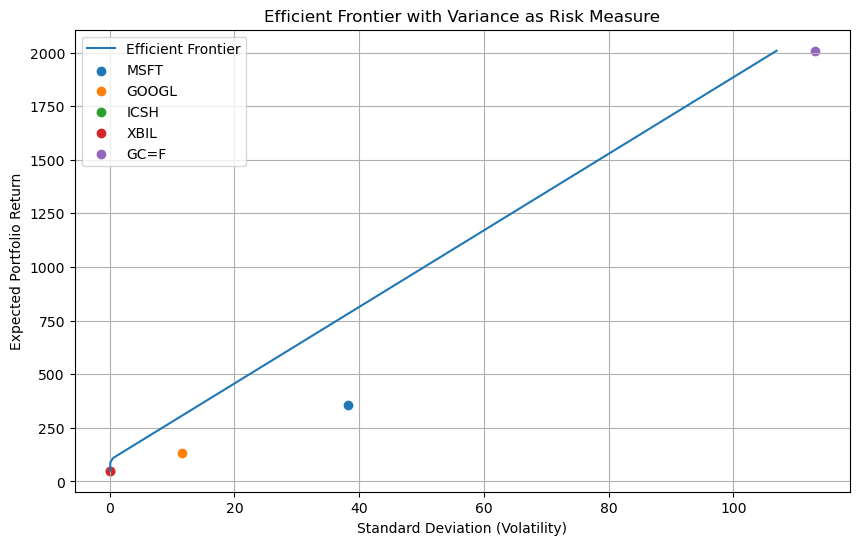

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.optimize import minimize

# Define the symbols for stocks and bonds
assets = ["MSFT", "GOOGL", "ICSH", "XBIL", "GC=F"]

# Fetch historical data for each symbol
data = {}
for symbol in assets:
    data[symbol] = yf.download(symbol, period="1y")

# Create a DataFrame to store the close prices
close_prices = pd.DataFrame(columns=assets)

# Populate the DataFrame with close prices
for symbol in assets:
    close_prices[symbol] = data[symbol]['Close']
close_prices.dropna(inplace=True)

# Calculate daily returns
returns = close_prices.dropna()

# Calculate mean return and covariance matrix
mean_return = returns.mean()
cov_matrix = returns.cov()

# Number of assets
n_assets = len(assets)

# Define the objective function to minimize volatility
def objective_function(weights):
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return portfolio_std

# Define constraints for optimization
constraints = [{'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}]

# Define bounds for each weight (between 0 and 1)
bounds = tuple((0, 1) for _ in range(n_assets))

# Initialize arrays to store portfolio weights and metrics
portfolio_weights = []
portfolio_std = []

# Iterate over a range of target returns to find the efficient frontier
target_returns = np.linspace(mean_return.min(), mean_return.max(), num=100)
for target_return in target_returns:
    # Define constraint for target return
    constraints.append({'type': 'eq', 'fun': lambda weights: np.dot(weights, mean_return) - target_return})
    
    # Minimize volatility for the given target return
    initial_guess = np.repeat(1 / n_assets, n_assets)
    result = minimize(objective_function, initial_guess, method='SLSQP', bounds=bounds, constraints=constraints[-1])
    
    # Store results
    portfolio_weights.append(result.x)
    portfolio_std.append(result.fun)

# Convert lists to arrays
portfolio_weights = np.array(portfolio_weights)
portfolio_std = np.array(portfolio_std)

# Plot efficient frontier
plt.figure(figsize=(10, 6))
plt.plot(portfolio_std, target_returns, linestyle='-', marker='', label='Efficient Frontier')

# Plot individual assets as points
for i, symbol in enumerate(assets):
    plt.scatter(np.sqrt(cov_matrix.iloc[i, i]), mean_return[i], marker='o', label=symbol)

plt.title('Efficient Frontier with Variance as Risk Measure')
plt.xlabel('Standard Deviation (Volatility)')
plt.ylabel('Expected Portfolio Return')
plt.legend()
plt.grid(True)
plt.show()
